# <b style='color:yellow;'> KNN </b>
* Este Jupyter tem como função treinar um `KNN` com os melhores parametros determinados por um `RandomSearch`.

-> Treino com o dataset completo, dados femininos e masculinos e sem as semanas como features.

---

Bibliotecas/Módulos

In [33]:
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle as pkl
import seaborn as sns
import sys

from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, accuracy_score, matthews_corrcoef, classification_report, confusion_matrix, f1_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

Configurações dos logs

In [2]:
logger = logging.getLogger("KNN")
logger.setLevel(logging.DEBUG)
handler = logging.StreamHandler(sys.stderr)
formatter = logging.Formatter('%(name)s - %(levelname)s - [+] ------- %(message)s -------') 
handler.setFormatter(formatter)
logger.handlers = [handler]

Cores

In [3]:
RED = "\033[1;31m"
BLUE = "\033[1;34m"
GREEN = "\033[1;32m"
PINK = "\033[1;45m"
HEADER = '\033[95m'
OKBLUE = '\033[94m'
OKCYAN = '\033[96m'
OKGREEN = '\033[92m'
WARNING = '\033[93m'
FAIL = '\033[91m'
ENDC = '\033[0m'
BOLD = '\033[1m'
UNDERLINE = '\033[4m'
MAG = "\033[1;45m"

----

## Preparando os dados

In [4]:
df = pd.read_csv("dados_FEM_MAS_10_voluntarios_s_semanas_15_sinais_noout.csv")

In [5]:
df.sample()

,0,1,2,3,4,5,6,7,8,9,...,1991,1992,1993,1994,1995,1996,1997,1998,1999,label
7412,-33,-5,-16,72,-36,-13,-25,-3,-1,-15,...,26,-104,6,-7,-22,26,0,69,-31,0


Removendo possíveis linhas vazias

In [6]:
df = df.dropna()

Verificando tamanho do dataset

In [7]:
len(df)

25200

Verificando a quantidade de colunas originais

In [8]:
len(df.columns)

2001

* Seleção da variável target e das features

In [9]:
y = df["label"]

In [10]:
df = df.drop(["label"], axis=1)

#### PCA

Aplicando o PCA para reduzir a dimensão dos dados.

In [12]:
pca = PCA(n_components=1000)

In [13]:
pca.fit(df)

PCA(n_components=1000)

In [14]:
%%time

pca_samples = pca.transform(df)

CPU times: user 27.4 s, sys: 8.89 s, total: 36.3 s
Wall time: 2.84 s


In [15]:
ps = pd.DataFrame(pca_samples)
ps.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,-35.068197,23.928768,1.186254,-151.129527,-42.556784,-148.023683,-53.831397,-28.461750,-41.857889,-104.510884,...,10.841163,14.769703,-54.473924,12.608171,22.659720,8.194705,-17.463126,46.477228,-38.694884,33.650136
1,-69.680457,36.845880,47.351802,-121.842658,-24.717552,-113.801059,-37.514149,-47.755131,-13.947044,-92.122796,...,8.589353,21.146134,-35.091094,8.505347,16.840718,-3.049575,-18.610821,17.933923,-16.171076,28.429343
2,-94.676600,38.038653,98.432548,-103.621516,-10.274245,-71.540178,-15.104704,-53.717266,24.066586,-97.600882,...,-19.134319,25.173619,-11.394027,17.001149,9.511772,3.467416,-14.527937,-14.584047,-5.583062,24.276519
3,-115.288910,36.334428,137.247898,-70.874058,-8.118221,-44.962368,-3.156064,-64.584880,46.295866,-89.627326,...,-32.469412,20.229873,15.384029,8.869566,19.258564,4.847967,-14.529834,-52.958011,8.730440,6.163119
4,-111.539509,45.575378,158.235942,-48.798876,-3.696119,-8.481742,11.270159,-71.759108,48.659401,-69.601917,...,-41.825481,35.835485,33.876126,7.890112,29.075359,-4.963837,-14.050961,-82.206263,19.021185,-18.013880


In [16]:
len(ps)

25200

In [17]:
len(ps.columns)

1000

In [18]:
X = ps

Separando os dados em dados de treino e teste

In [19]:
x_treino, x_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2, random_state=7)

#### Scaler

Aplicando Scaler para diminuir a diferença entre a maginitude dos dados, pois isso pode afetar muito o KNN

In [ ]:
scaler = StandardScaler()  
scaler.fit(x_treino)

x_treino = scaler.transform(x_treino)  
x_teste = scaler.transform(x_teste)

---

## Treinamento

### RandomSeach

Parâmetros do modelo escolhidos para otimização

In [46]:
values = {'n_neighbors':[2], 'algorithm': ["auto", "ball_tree", "kd_tree", "brute"]}

In [47]:
clf = KNeighborsClassifier()

In [48]:
def best_params(values: dict, clf: 'classificador', x_treino: np.array, x_teste: np.array, y_treino: np.array, y_teste: np.array) -> list:
    '''
        Instancia um classificador de busca e procura os melhores parâmetros para o modelo.
        
        Params
        ------
        :values: parametros a serem testados
        :clf: instancia do classificador desejado
        :x_treino: dados de treino
        :x_teste: dados de teste
        :y_treino: dados de treino -labels
        :y_teste: dados de treino - labels
        
        Return
        ------
        :best_params: lista com os melhores parametros
    '''
    
    logger.info('Instanciando KNN')
    random_clf = RandomizedSearchCV(clf, param_distributions=values, n_iter=200)
    
    logger.info('Treinando KNN')
    random_clf.fit(x_treino, y_treino)
    
    
    logger.info('Parametros KNN')
    print(RED, random_clf.get_params())
    
    logger.info('Best Params KNN')
    best_params = random_clf.best_params_
    print(BLUE, best_params)
    
    return best_params

In [49]:
%%time

try:
    best = best_params(values, clf, x_treino, x_teste, y_treino, y_teste)

except Exception as error:
    logger.warning('Aconteceu algum problema...')
    logger.critical(error)

else:
    logger.info('Ok')
    
finally:
    logger.info('Busca finalizada')

SVM - INFO - [+] ------- Instanciando KNN -------
INFO:SVM:Instanciando KNN
SVM - INFO - [+] ------- Treinando KNN -------
INFO:SVM:Treinando KNN
/home/saraselis/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 4 is smaller than n_iter=200. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
SVM - INFO - [+] ------- Parametros KNN -------
INFO:SVM:Parametros KNN
SVM - INFO - [+] ------- Best Params KNN -------
INFO:SVM:Best Params KNN
SVM - INFO - [+] ------- Ok -------
INFO:SVM:Ok
SVM - INFO - [+] ------- Busca finalizada -------
INFO:SVM:Busca finalizada


 {'cv': None, 'error_score': nan, 'estimator__algorithm': 'auto', 'estimator__leaf_size': 30, 'estimator__metric': 'minkowski', 'estimator__metric_params': None, 'estimator__n_jobs': None, 'estimator__n_neighbors': 5, 'estimator__p': 2, 'estimator__weights': 'uniform', 'estimator': KNeighborsClassifier(), 'n_iter': 200, 'n_jobs': None, 'param_distributions': {'n_neighbors': [2], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}, 'pre_dispatch': '2*n_jobs', 'random_state': None, 'refit': True, 'return_train_score': False, 'scoring': None, 'verbose': 0}
 {'n_neighbors': 2, 'algorithm': 'ball_tree'}
CPU times: user 12min 45s, sys: 1.48 s, total: 12min 46s
Wall time: 10min 35s


Melhores parâmetros:

 {'n_neighbors': 2, 'algorithm': 'ball_tree'}

----

### Método do cotovelo

Além de escolher os melhores parâmetros no KNN é necessário também escolher o melhor valor para a quantidade de k-vizinhos.
Para isso será utilizado o método do cotovelo.

In [29]:
%%time

error = []

for i in range(1, 20):  
    knn = KNeighborsClassifier(n_neighbors=i, algorithm= "ball_tree")
    
    knn.fit(x_treino, y_treino)
    pred_i = knn.predict(x_teste)
    error.append(np.mean(pred_i != y_teste))

CPU times: user 47min 7s, sys: 34.6 s, total: 47min 41s
Wall time: 47min 41s


Text(0, 0.5, 'Mean Error')

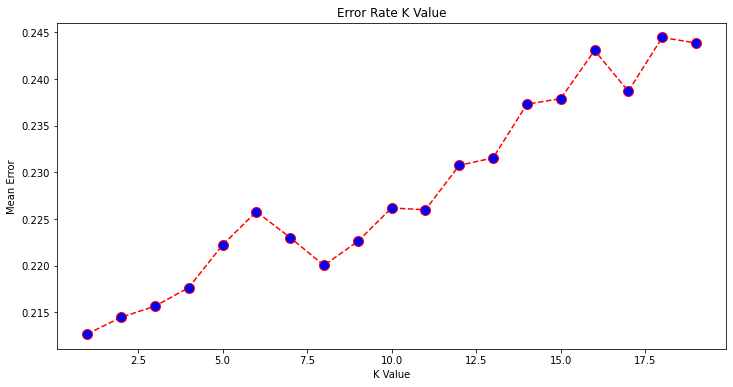

In [30]:
plt.figure(figsize=(12, 6))  
plt.plot(range(1, 20), error, color='red', linestyle='dashed', marker='o',  
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')  
plt.xlabel('K Value')  
plt.ylabel('Mean Error')  

Como podemos observar, aumentar a quantidade de vizinhos, aumenta também o erro da predição.

----

### KNN

In [31]:
def classificador(x_treino: np.array, y_treino: np.array, x_teste: np.array, y_teste: np.array) -> list:
    '''
        Treina um classificador com os melhores parametros possíveis.
        
        Params
        ------
        :x_treino: dados de treino
        :x_teste: dados de teste
        :y_treino: dados de treino -labels
        :y_teste: dados de treino - labels
    
        Return
        ------
        :KNN: Modelo Random Forest treinado
        :resultados: métricas
    '''
    
    logger.info('Instanciando KNN')
      
    KNN = KNeighborsClassifier(n_neighbors=1, algorithm= "ball_tree")
    
    logger.info('Treinando KNN')
    KNN.fit(x_treino, y_treino)
    
    logger.info('Predict')
    p = KNN.predict_proba(x_teste)[:, 1]
    categorias = KNN.predict(x_teste)
    
    logger.info('Métricas: \n \n')
    
    logger.info('Roc')
    roc = roc_auc_score(y_teste, p)
    print(OKBLUE, "Roc \n" + str(roc) + "\n")
    
    logger.info("F1")
    f1 = f1_score(y_teste, categorias, average="weighted")
    print(GREEN, "F1 \n" + str(f1) + "\n")
    
    logger.info('Acurácia')
    acc = accuracy_score(y_teste, categorias)
    print(OKCYAN, "Acc \n" + str(acc) + "\n")
    
    logger.info("Mcc")
    mcc = matthews_corrcoef(y_teste, categorias)
    print(WARNING, "Mcc \n" + str(mcc) + "\n")
    
    logger.info('Class Report')
    resultados = classification_report(y_teste, categorias)
    print(ENDC, "Class Report \n" + resultados + "\n")
    
    mat = confusion_matrix(y_teste, categorias)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
    plt.xlabel('true label')
    plt.ylabel('predicted label');
    
    return KNN, resultados

SVM - INFO - [+] ------- Instanciando KNN -------
SVM - INFO - [+] ------- Treinando KNN -------
SVM - INFO - [+] ------- Predict -------
SVM - INFO - [+] ------- Roc -------
SVM - INFO - [+] ------- F1 -------
SVM - INFO - [+] ------- Acurácia -------
SVM - INFO - [+] ------- Mcc -------
SVM - INFO - [+] ------- Class Report -------
SVM - INFO - [+] ------- Ok -------
SVM - INFO - [+] ------- Treino finalizado -------


Métricas: 
 

 Roc 
0.7873046027365852

 F1 
0.7872989077783281

 Acc 
0.7873015873015873

 Mcc 
0.5746236834596783

 Class Report 
              precision    recall  f1-score   support

           0       0.78      0.79      0.79      2518
           1       0.79      0.78      0.79      2522

    accuracy                           0.79      5040
   macro avg       0.79      0.79      0.79      5040
weighted avg       0.79      0.79      0.79      5040


CPU times: user 4min 34s, sys: 3.13 s, total: 4min 37s
Wall time: 4min 37s


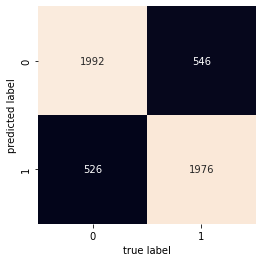

In [32]:
%%time

try:
    KNN, resultados = classificador(
                        x_treino,
                        y_treino,
                        x_teste,
                        y_teste)

except Exception as error:
    logger.warning('Aconteceu algum problema...')
    logger.critical(error)

else:
    logger.info('Ok')
    
finally:
    logger.info('Treino finalizado')

----

#### Exportando modelo

In [35]:
pkl.dump(KNN, open('modelos/knn_dados_FEM_MAS_10_voluntarios_s_semanas_15_sinais_noout.pkl', 'wb'))